In [115]:
import pandas as pd
import numpy as np
import re

from IPython.display import Markdown

from joblib import parallel_backend, dump, load

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, log_loss

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
            GridSearchCV

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from code.cleaner import preprocess
from code.viz import word_plot
from code.scoring import custom_scorer

sns.set()

In [2]:
sentiments = pd.read_csv(
    './data/judge-1377884607_tweet_product_company.csv',
    encoding='ISO-8859-1')
sentiments.tail()

tweet_text  \
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product

In [3]:
# sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
# sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [4]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Here, we'll split off the sentiments listed as "I can't
tell" into their own dataframe and drop them from the
original.

In [6]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

In [7]:
sw = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [8]:
preprocess(sentiments.head()['tweet_text'],sw)

['@wesley g hr tweet #rise dead need upgrade plugin station',
 '@jessedee know @fludapp awesome likely appreciate design also give free t',
 '@swonderlin wait #ipad also sale',
 'hope year festival crashy year',
 '@sxtxstate great stuff fri marissa mayer tim reilly tech book conference amp matt mullenweg wordpress']

In [9]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

In [10]:
X = sentiments[['tokenized','tokens']]
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

train = X_train.merge(
    y_train,left_index=True,right_index=True
    )
test = X_test.merge(
    y_test,left_index=True,right_index=True
    )

Index(['#ipad', 'get', 'launch', 'line'], dtype='object')


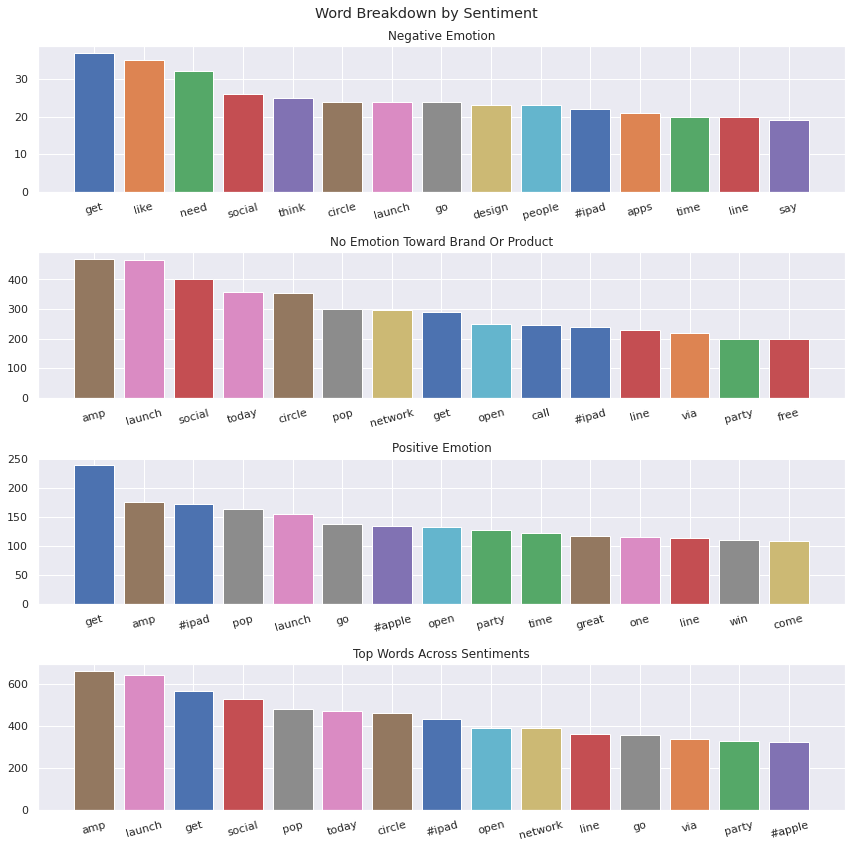

In [11]:
# train = X_train.merge(
#     y_train,left_index=True,right_index=True
#     )
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['amp', 'go', 'social'], dtype='object')


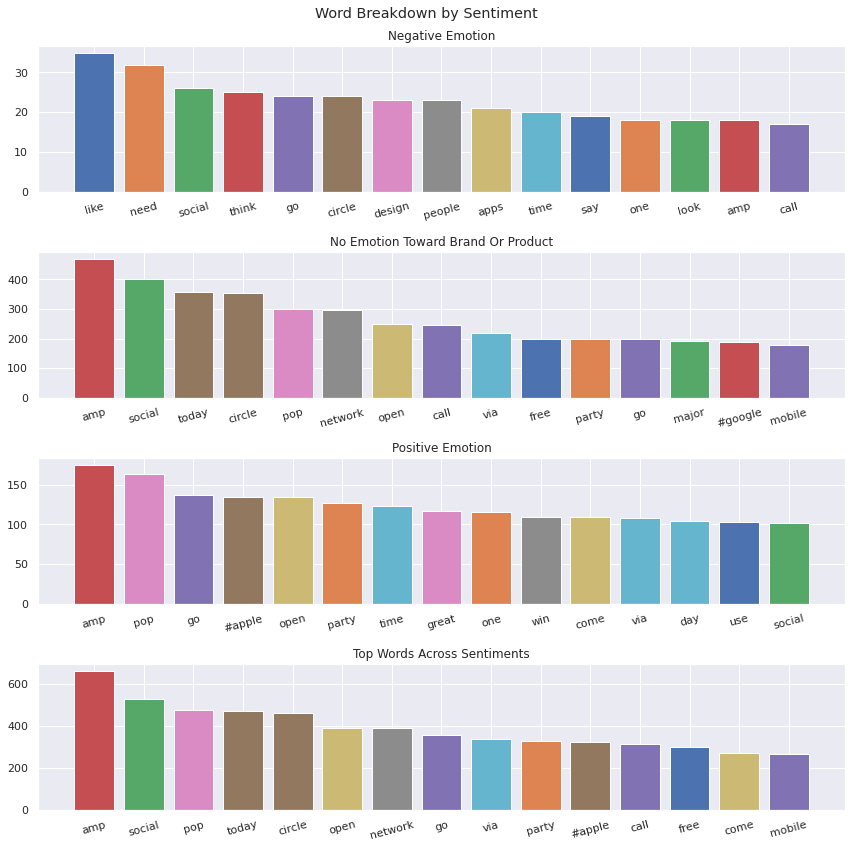

In [12]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['today'], dtype='object')


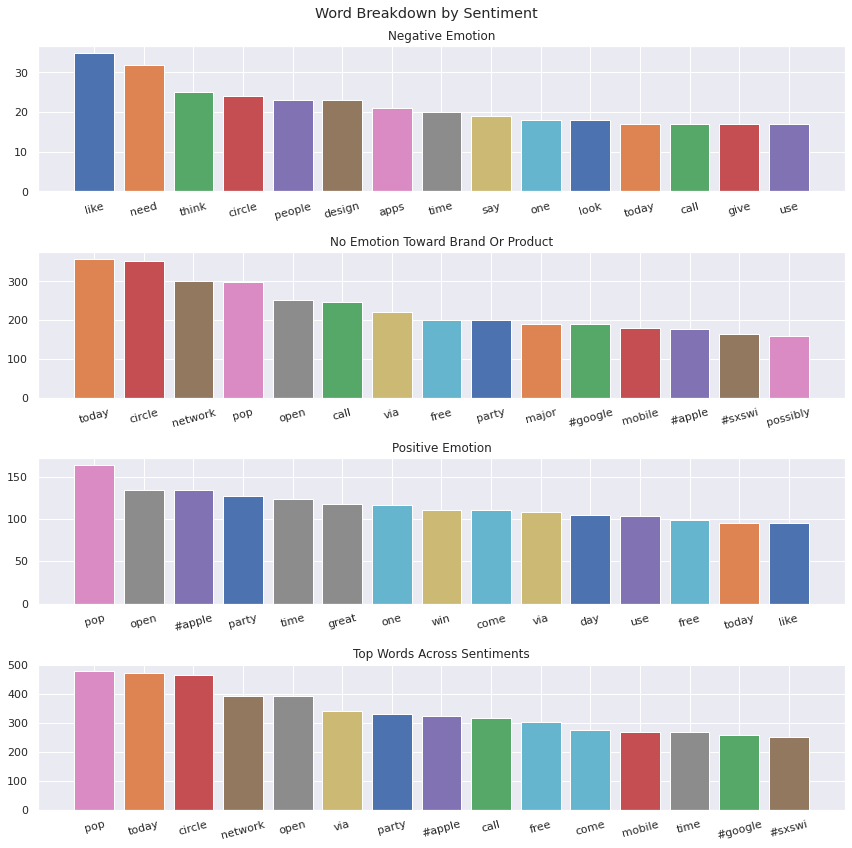

In [13]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['pop'], dtype='object')


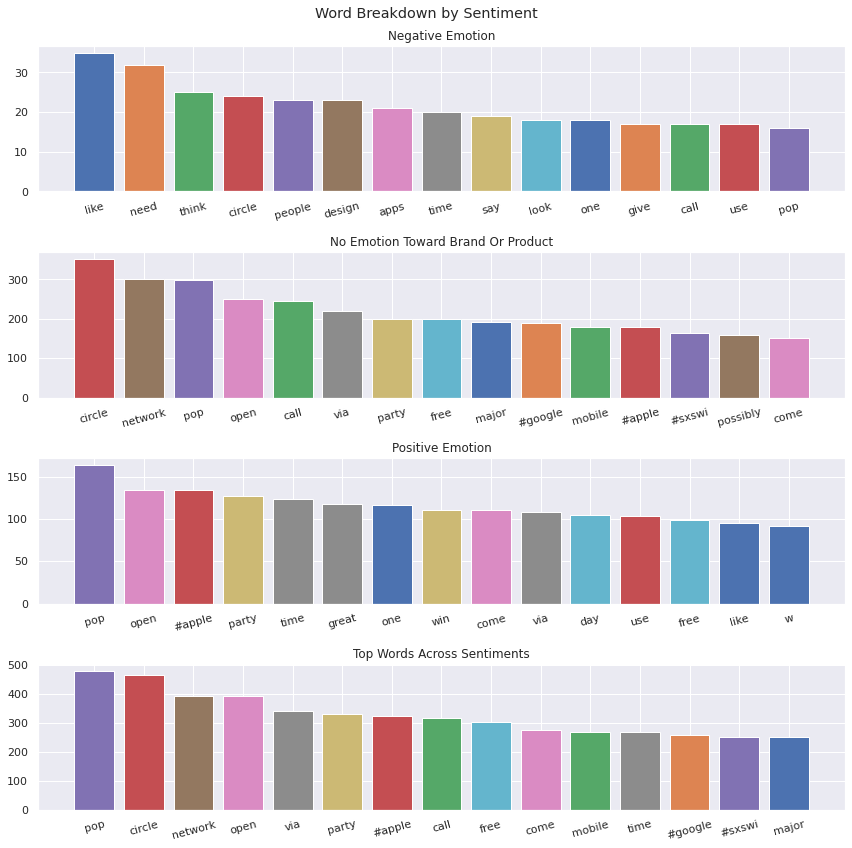

In [14]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

In [63]:
WordCloud?

Init signature:
WordCloud(
    font_path=None,
    width=400,
    height=200,
    margin=2,
    ranks_only=None,
    prefer_horizontal=0.9,
    mask=None,
    scale=1,
    color_func=None,
    max_words=200,
    min_font_size=4,
    stopwords=None,
    random_state=None,
    background_color='black',
    max_font_size=None,
    font_step=1,
    mode='RGB',
    relative_scaling='auto',
    regexp=None,
    collocations=True,
    colormap=None,
    normalize_plurals=True,
    contour_width=0,
    contour_color='black',
    repeat=False,
    include_numbers=False,
    min_word_length=0,
    collocation_threshold=30,
)
Docstring:     
Word cloud object for generating and drawing.

Parameters
----------
font_path : string
    Font path to the font that will be used (OTF or TTF).
    Defaults to DroidSansMono path on a Linux machine. If you are on
    another OS or don't have this font, you need to adjust this path.

width : int (default=400)
    Width of the canvas.

height : int (default=2

In [64]:
from matplotlib.colors import ListedColormap

In [77]:
test_map = ListedColormap(sns.color_palette('colorblind',as_cmap=True,n_colors=20))
canvamap = [
    '#3f5896',
    '#494f56',
    '#4f6ab3',
    '#5773b8',
    '#76d3fb',
    '#db868e',
    '#e28a5c',
    '#f4d9bc',
    '#f7b2b0',
    '#fddf75',
    '#ffcc66'
]
test_map = ListedColormap(canvamap)

(-0.5, 1799.5, 799.5, -0.5)

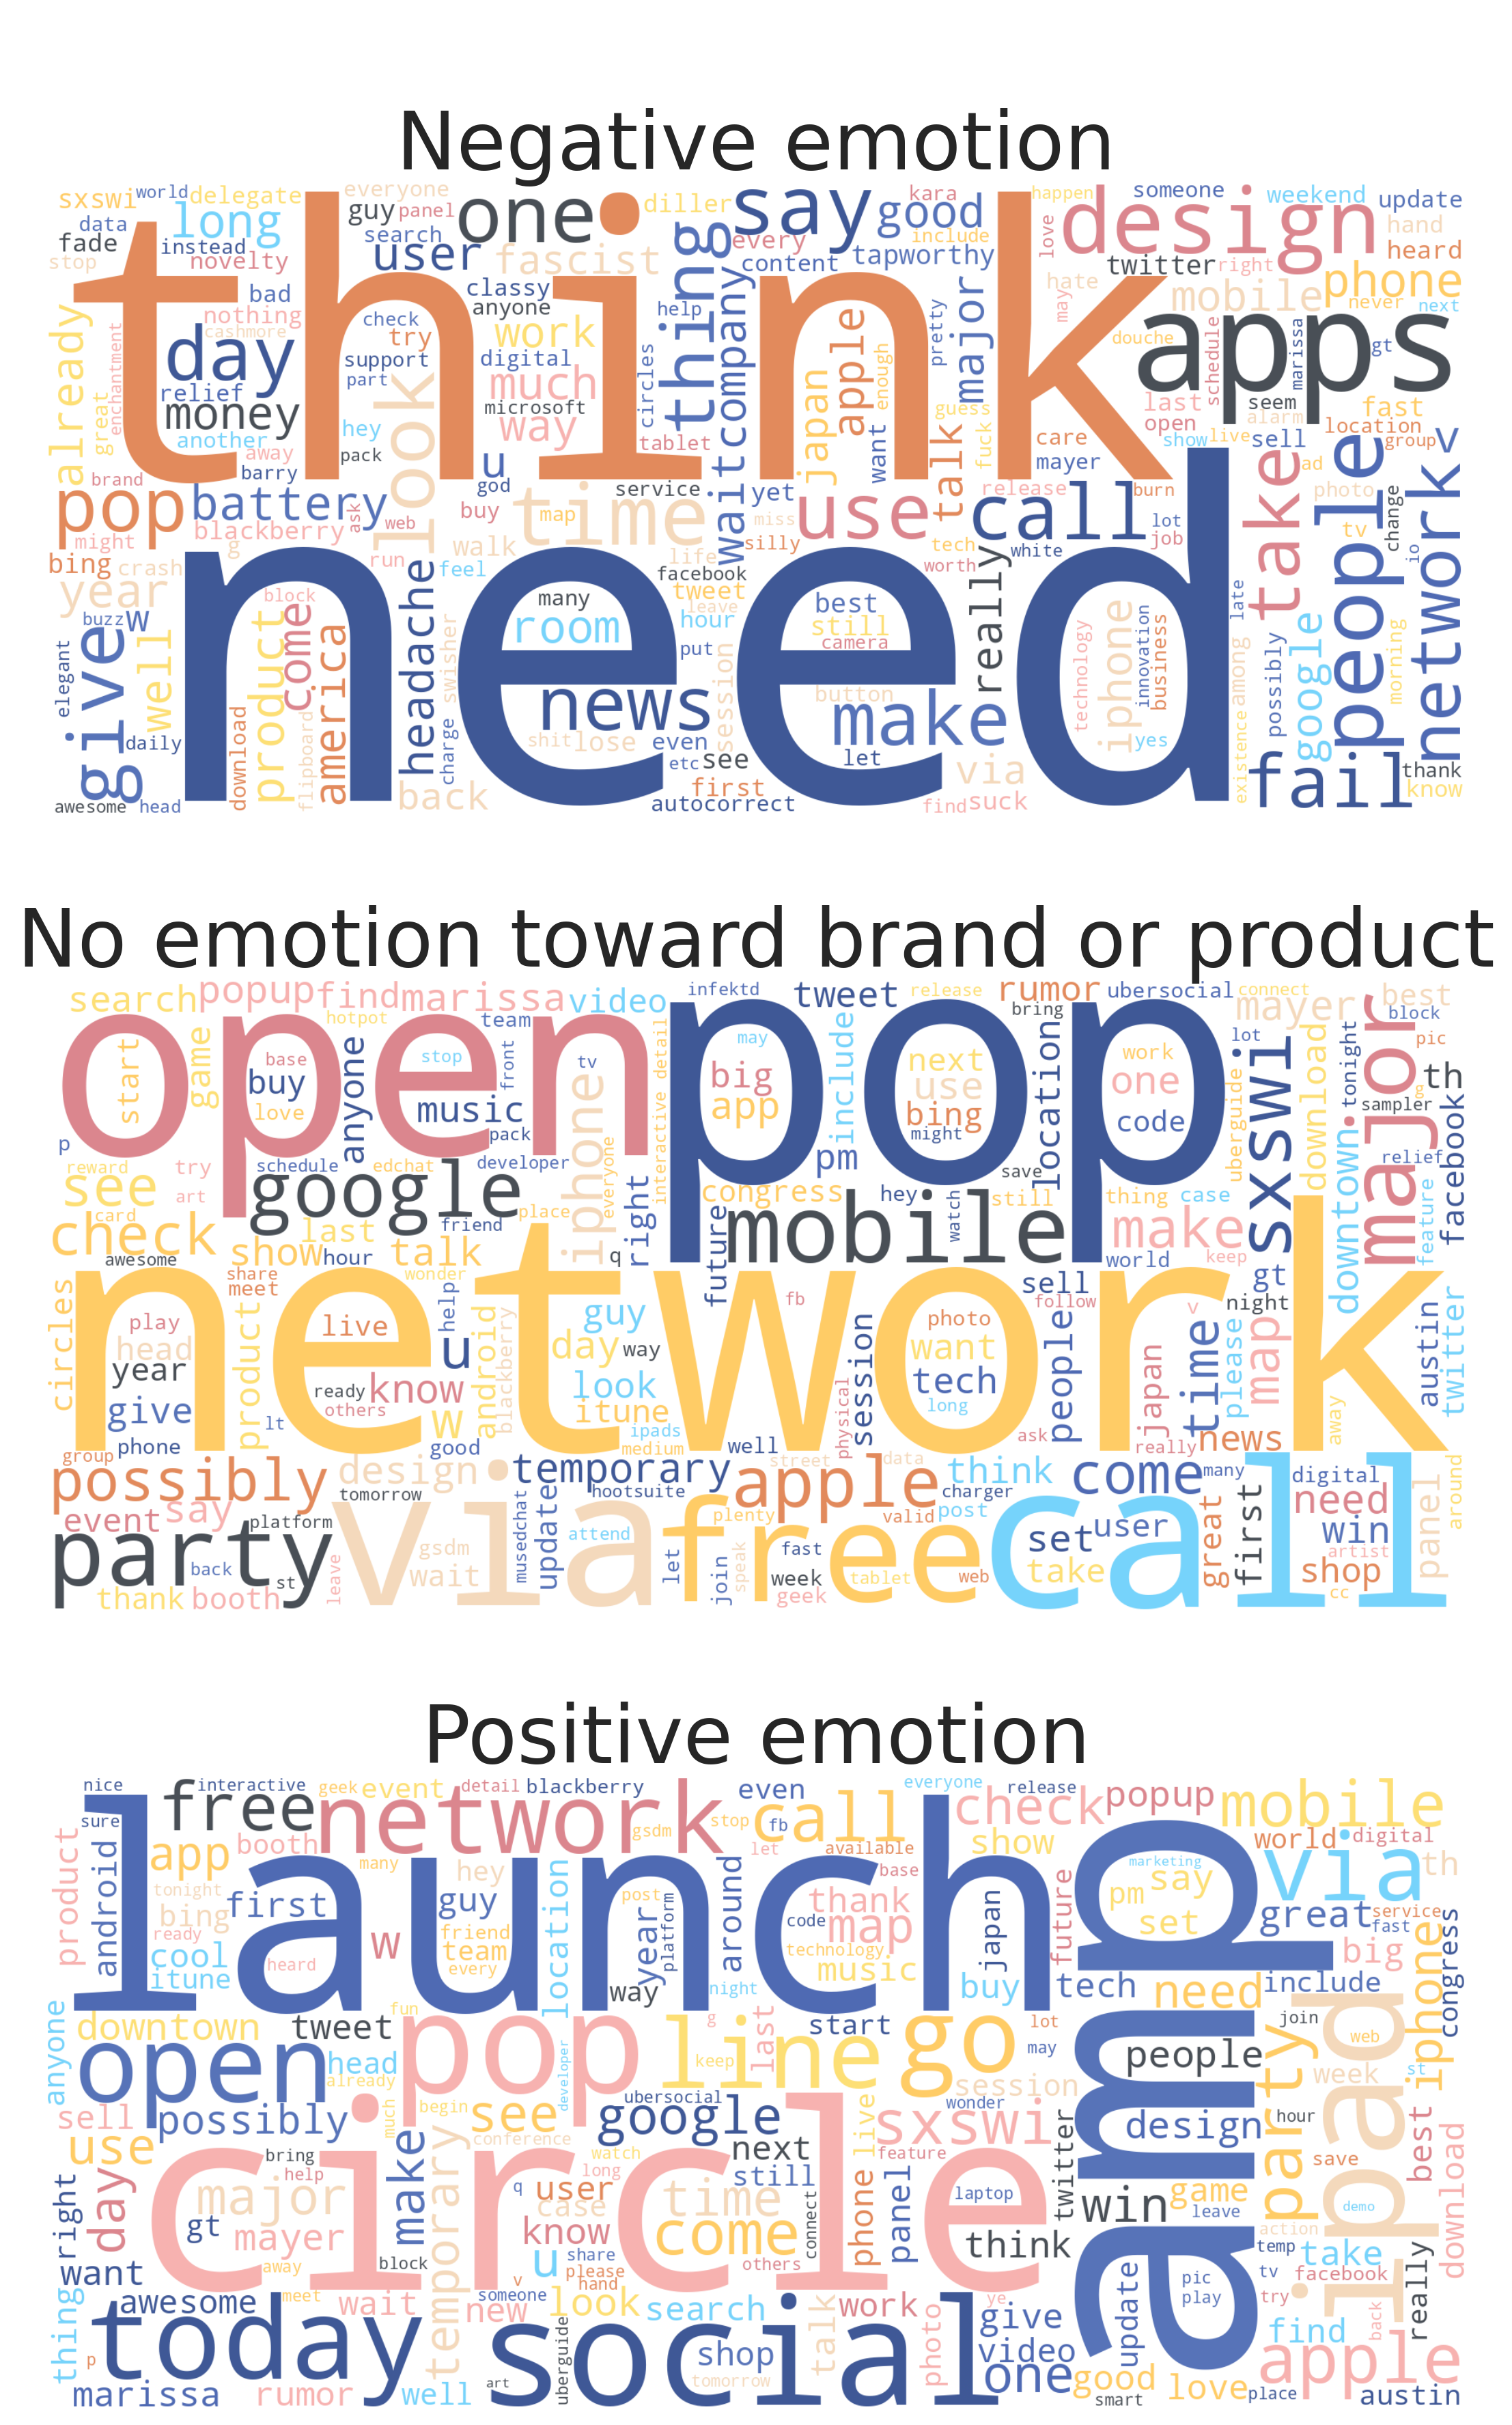

In [82]:
fig, ax = plt.subplots(3,1,figsize=(10,14),dpi=250)
for i, emo in enumerate(train['sentiment'].unique()):
    tmp_ = train[train['sentiment'] == emo]
    ax_ = ax[i]
    wordcloud = WordCloud(
        collocations=False, width=1800,height=800,
        background_color="#ffffff00",
        colormap=test_map
        ).generate(' '.join(tmp_['tokenized']))
    ax_.set_title(f"\n{emo}",fontsize=34)
    ax_.imshow(wordcloud, interpolation='bilinear')
    ax_.axis('off')
plt.tight_layout(pad=0)

(-0.5, 1799.5, 799.5, -0.5)

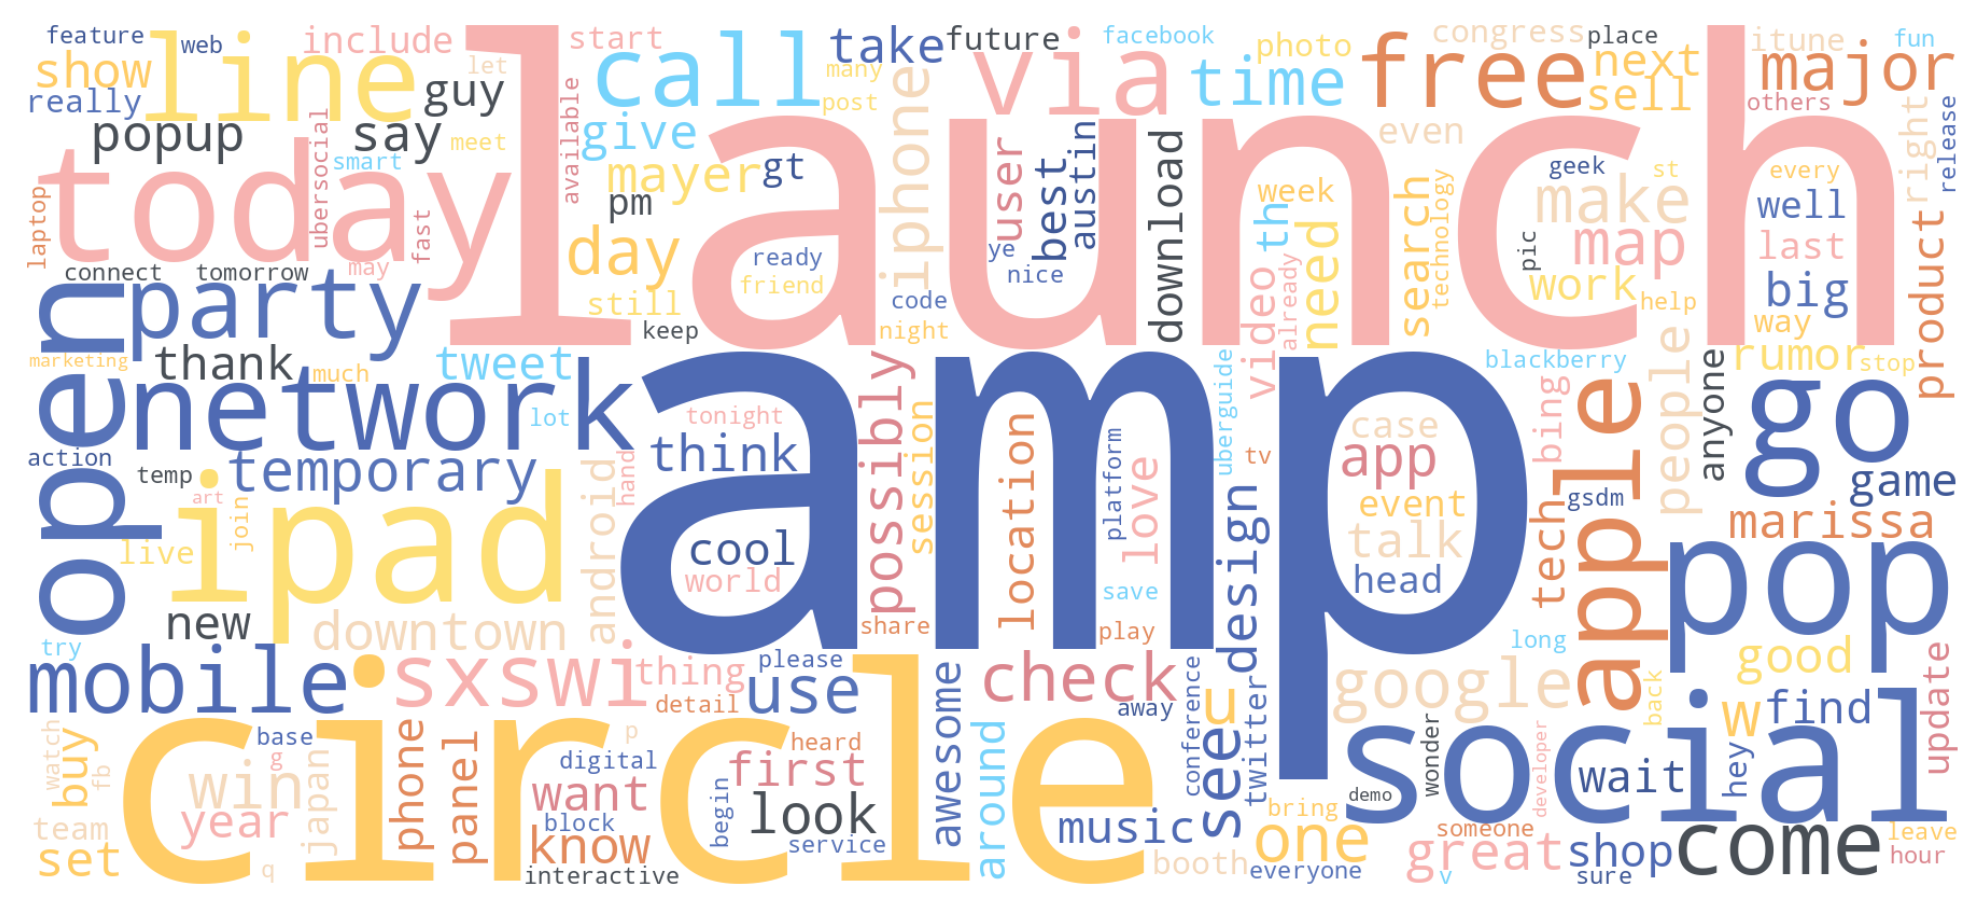

In [84]:
fig, ax = plt.subplots(1,1,figsize=(10,8),dpi=250)
wordcloud.generate(' '.join(sentiments['tokenized']))
ax.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

We can see that the word "Circle" appears at a high
volume in every category. Looking through the data,
this is because Google launched a social network called
"Circle" that was a large topic during the SXSW event
that was taking place during the time of our dataset's
collection.

In [16]:
sw.extend(['circle'])
train['tokenized'],train['tokens'] = \
    preprocess(train['tokenized'],sw,ret_tokens=True)

In [17]:
test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)
tfidf = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)

train_tfidf = tfidf.fit_transform(train['tokenized'])
test_tfidf = tfidf.transform(test['tokenized'])

train_vec = pd.DataFrame(train_tfidf.toarray(),columns=tfidf.get_feature_names())
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

In [85]:
test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)
test_tfidf = tfidf.transform(test['tokenized'])
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

In [37]:
rfc = RandomForestClassifier(n_jobs=-2,random_state=13)
knc = KNeighborsClassifier(n_jobs=-2)
mnb = MultinomialNB()
svc = SVC(random_state=13)

scoring = make_scorer(custom_scorer)

rfc_grid = {
    'max_depth':[15,20,25,30],
    'min_samples_split':[10,15,20]
}
knc_grid = {
    'n_neighbors':[3,5,7,9]
}
mnb_grid = {
}
svc_grid = {
    'kernel':['poly','rbf'],
    'degree':[3,4]
}

rfc = GridSearchCV(
    rfc,rfc_grid,
    scoring=scoring
)
knc = GridSearchCV(
    knc,knc_grid,
    scoring=scoring
)
mnb = GridSearchCV(
    mnb,mnb_grid,
    scoring=scoring
)
svc = GridSearchCV(
    svc,svc_grid,
    scoring=scoring
)

classifiers = [rfc,knc,mnb,svc]

majority_length = len(train[train['sentiment'] == 'No emotion toward brand or product'])
sub_majority_length = len(train[train['sentiment'] == 'Positive emotion'])

if sub_majority_length*2 > majority_length:
    scale_size = sub_majority_length*2
else:
    scale_size = majority_length

sm_dict = {
    "No emotion toward brand or product"    : int(scale_size),
    "Positive emotion"                      : int(scale_size*0.5),
    "Negative emotion"                      : int(scale_size*0.5)
}

o = SMOTE(random_state=13)
# o_grid = {
#     'sampling_strategy':['minority','auto',sm_dict]
# }
o_grid = ['minority','auto',sm_dict]

# o = GridSearchCV(
#     o,o_grid,
#     scoring=scoring
# )
pipe = imbPipeline(
    steps=[
        ('o',o),
        ('search',DummyClassifier())
    ]
)

grid = [
    {'o':['passthrough'],
    'search':[*classifiers]},
    {'o':[o],
    'o__sampling_strategy':o_grid,
    'search':[*classifiers]}
]

In [38]:
gs = GridSearchCV(
    pipe,grid,scoring=scoring,
    verbose=3
)
# gs.fit(train_vec,train['sentiment'])

In [39]:
with parallel_backend('threading',n_jobs=-2):
    gs.fit(train_vec,train['sentiment'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 23 concurrent workers.


[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)), score=0.579, total=   4.9s
[CV] o=SMOTE(random_state=13), o__sampling_strategy=minority, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)), score=0.597, total=   5.0s
[CV] o=SMOTE(random_state=13), o__sampling_strategy=minority, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=passthrough, search=GridSearchCV(estimator=Multino

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.3s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.8s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.9s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.4s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 236, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/sit

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.4s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   1.1s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 236, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/sit

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.3s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)), score=0.574, total= 8.2min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 236, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/sit

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   2.4s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)), score=nan, total=   2.4s
[CV] o=SMOTE(random_state=13), o__samp

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 236, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/sit

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.4s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)) 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)), score=nan, total=   1.1s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)), score=nan, total=   1.0s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.6s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.9s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product'

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.5s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_sc

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4764) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(
/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.3s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)) 
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_sc

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 236, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/jd/anaconda3/envs/learn-env/lib/python3.8/sit

[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4764, 'Positive emotion': 2382.0, 'Negative emotion': 2382.0}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)), score=nan, total=   0.3s
[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)), score=0.476, total= 4.3min
[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(custom_scorer)), score=0.493, total= 4.5min
[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13)

[Parallel(n_jobs=-2)]: Done  62 out of  80 | elapsed: 12.4min remaining:  3.6min


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring=make_scorer(custom_scorer)), score=0.605, total= 7.5min
[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)), score=0.605, total=12.7min
[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)), score=0.601, total=12.8min
[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring=make_scorer(custom_scorer)), score=0.617, total=13.0min
[C

[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed: 32.2min finished


In [42]:
dump(gs.best_estimator_,'./data/best_estimator.pkl')

['./data/best_estimator.pkl']

In [40]:
gs.best_estimator_, \
gs.best_estimator_['search'], \
gs.best_estimator_['search'].best_params_, \
gs.best_score_

(Pipeline(steps=[('o', SMOTE(random_state=13)),
                 ('search',
                  GridSearchCV(estimator=SVC(random_state=13),
                               param_grid={'degree': [3, 4],
                                           'kernel': ['poly', 'rbf']},
                               scoring=make_scorer(custom_scorer)))]),
 GridSearchCV(estimator=SVC(random_state=13),
              param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
              scoring=make_scorer(custom_scorer)),
 {'degree': 3, 'kernel': 'rbf'},
 0.6219694465272108)

In [25]:
best_top   = gs.best_estimator_.steps[0][1]
best_inner = gs.best_estimator_['search'].best_estimator_

In [26]:
best_model = imbPipeline(
    steps=[
        ('scaler',best_top),
        ('model',best_inner)
    ]
)

In [27]:
best_model.fit(train_vec,train['sentiment'])

Pipeline(steps=[('scaler', SMOTE(random_state=13)),
                ('model', SVC(random_state=13))])

In [28]:
y_pred = best_model.predict(train_vec)
train['sentiment'].value_counts(), \
f1_score(y_pred,train['sentiment'],average=None)

(No emotion toward brand or product    4310
 Positive emotion                      2382
 Negative emotion                       456
 Name: sentiment, dtype: int64,
 array([0.79890311, 0.90939044, 0.8579932 ]))

In [87]:
test_pred = best_model.predict(test_vec)
test['sentiment'].value_counts(), \
f1_score(test_pred,test['sentiment'],average=None)[1:].mean()

(No emotion toward brand or product    1078
 Positive emotion                       596
 Negative emotion                       114
 Name: sentiment, dtype: int64,
 0.6605992764749453)

In [43]:
best_testimator = load('./data/best_estimator.pkl')

In [44]:
f1_score(
    best_testimator.predict(train_vec),
    train['sentiment'],
    average=None
)

array([0.79890311, 0.90939044, 0.8579932 ])

In [61]:
sentiments['sentiment'].value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: sentiment, dtype: float64

In [ ]:
best_testimator['search'].best_estimator_

In [90]:
rc_est = preprocess(reclassify['tweet_text'],sw)
rc_tfidf = tfidf.transform(rc_est)
rc_vec = pd.DataFrame(rc_tfidf.toarray(),columns=tfidf.get_feature_names())
reclassify['predicted_sentiment'] = best_testimator.predict(rc_vec)


In [176]:
rc_neu = reclassify[
    reclassify['predicted_sentiment']=='No emotion toward brand or product'
    ].sample(5)['tweet_text'].values
rc_pos = reclassify[
    reclassify['predicted_sentiment']=='Negative emotion'
    ].sample(5)['tweet_text'].values
rc_neg = reclassify[
    reclassify['predicted_sentiment']=='Positive emotion'
    ].sample(5)['tweet_text'].values

tweet_types = [
    ('Neutral tweets',rc_neu),
    ('Positive tweets',rc_pos),
    ('Negative tweets',rc_neg)]
md = []
nlc = '\n'
for type_ in tweet_types:
    header = f"\n\n<br/>\n<br/>\n\n | {type_[0]} |\n|---|"
    body = []
    for item_ in type_[1]:
        body.append(f"| {item_} |")
    md.append(f"{header}\n{nlc.join(body)}")

Markdown('\n'.join(md))



<br/>
<br/>

 | Neutral tweets |
|---|
| RT @mention Has spontaniety in life been replaced by technology? When your iPhone battery dies you go home. Great ? At #busy #sxsw |
| Liveblog from #SXSW: Can indie #iPhone game development survive? {link} #games |
| How to design for baby boomers: DON'T. John McRee on #iPad design #sxsw #yourmom |
| I can now say that Google got me drunk #sxsw #h4ckers |
| Kawasaki: key to enchantment = trustworthiness of Zappos + likeability of Richard Branson + product of Apple #sxsw #mccannsxsw #mrmworldwide |


<br/>
<br/>

 | Positive tweets |
|---|
| The iPad 2 is the also a cartoonishly large digital camera. #SXSW #CStejas {link} |
| I really think that most of the iPad 2 stock went down to #SXSW. |
| I agree with @mention on their @mention concerns, but your #sxsw #microformats panelist is just condescending and rude. |
| RT @mention Best thing I've heard this weekend at #SXSW &quot;I gave my iPad 2 money to #Japan relief. I don't ne... {link} |
| I think google circles was an effect of crop `circle` #SXSW #randomly |


<br/>
<br/>

 | Negative tweets |
|---|
| It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW |
| &quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat? |
| I'll bet there's a lot of nerds at #SXSW using the #iPhone Light Saber app in barroom brawls instead of their fists. |
| Comprando mi iPad 2 en el #SXSW (@mention Apple Store, SXSW w/ 62 others) {link} |
| Catch 22Û_ I mean iPad 2 at #SXSW : {link} |